#### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

### Functions

In [2]:
def plot_confustion_matrix(y_true, y_pred):
    c_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = [f'Count {value}' for value in c_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()


def test_model(x, y, model_type, **kwargs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
    model = model_type(**kwargs)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return {
        'model': model,
        'y_true': y_test,
        'y_pred': predictions,
        'x': x,
        'y': y
    }


def scale_data(df: pd.DataFrame, scaler=MinMaxScaler, **kwargs):
    df = df.copy()
    scaler = scaler(**kwargs)
    column_names = df.columns
    scaled_data = scaler.fit_transform(df)
    new_df = pd.DataFrame(scaled_data, columns=column_names)
    return new_df


list_to_str = lambda x: ", ".join([str(item) for item in x])
class_counts_to_list = lambda class_count: [f"{key}: {item}" for key, item in class_count.items()] 

#### Pre Processing

In [3]:
test_df = pd.read_csv('./data/class_test.csv')
train_df = pd.read_csv('./data/class_train.csv')
imbalanced_df = pd.concat([test_df, train_df])
imbalanced_class_count = imbalanced_df['Outcome'].value_counts()
print(f'Imbalanced dataset contains: {imbalanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(imbalanced_class_count))}]')

Imbalanced dataset contains: 116 rows with the class balances [1: 64, 0: 52]


In [4]:
fig, ax = plt.subplots(figsize=(24, 18))
hm = sns.heatmap(imbalanced_df.corr(), cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

#### Scaling data with MinMaxScaler

In [ ]:
# Scaling Data
x = imbalanced_df.copy()   
y = x.pop('Outcome')
x_scaled = scale_data(x, scaler=MinMaxScaler)

### Handling data imbalance with SMOTE

In [ ]:
smote = SMOTE(random_state=42)
x_balanced, y_balanced = smote.fit_resample(x_scaled, y)
balanced_df = pd.concat([x_balanced, y_balanced], axis=1)
balanced_class_count = balanced_df['Outcome'].value_counts()

print(f'Imbalanced dataset contains: {imbalanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(imbalanced_class_count))}]')
print(f'Balanced dataset contains: {balanced_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(balanced_class_count))}]')

Imbalanced dataset contains: 116 rows with the class balances [1: 64, 0: 52]
Balanced dataset contains: 128 rows with the class balances [0: 64, 1: 64]


### Baselines on Logistic regression and Support Vector Machine with multiple kernels.

0.7586206896551724


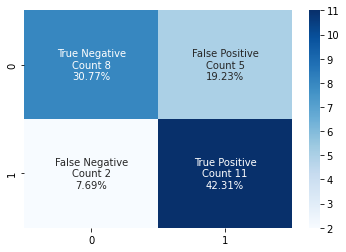

In [ ]:
# Testing Logistic regression
result = test_model(x_balanced,y_balanced, LogisticRegression)
y_true, y_pred = result['y_true'], result['y_pred']
baseline_lr_f1 = f1_score(y_true, y_pred)
print(baseline_lr_f1)
plot_confustion_matrix(y_true, y_pred)

0.6428571428571429


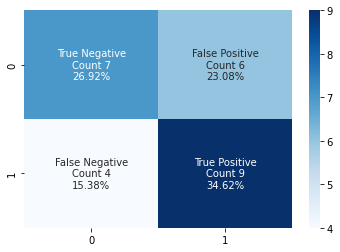

In [ ]:
# Testing Support vector machine with kernel rbf
result = test_model(x_balanced, y_balanced, SVC, kernel='rbf')
y_true, y_pred = result['y_true'], result['y_pred']
baseline_svm_rbf_f1 = f1_score(y_true, y_pred)
print(baseline_svm_rbf_f1)
plot_confustion_matrix(y_true, y_pred)

0.6666666666666667


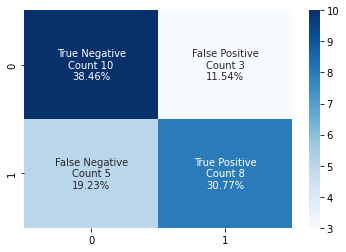

In [ ]:
# Testing support vector machine with kernel linear
result = test_model(x_balanced, y_balanced, SVC, kernel='linear')
y_true, y_pred = result['y_true'], result['y_pred']
baseline_svm_linear_f1 = f1_score(y_true, y_pred)
print(baseline_svm_linear_f1)

plot_confustion_matrix(y_true, y_pred)

### DIMENSIONALITY REDUCTION WITH PCA

In [ ]:
nr_of_components = int(min(x_balanced.shape[0], x_balanced.shape[1]))
pca = PCA(nr_of_components)
pca.fit(x_balanced)
ratios = np.cumsum(pca.explained_variance_ratio_)

# Finding kneepoint of convergence
kneedle = KneeLocator(range(len(ratios)), ratios, curve="concave", direction='increasing')
print(f'With {kneedle.knee} number of components we keep {ratios[kneedle.knee] * 100 }% of the information ')

With 40 number of components we keep 95.59330948832726% of the information 


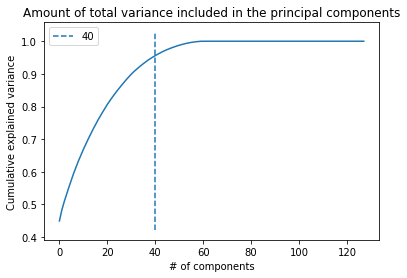

In [ ]:
plt.plot(range(len(ratios)), ratios)
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label=kneedle.knee)
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')
plt.title("Amount of total variance included in the principal components")
plt.legend()
plt.show()

In [ ]:
x_transformed = pca.transform(x_balanced)
x_transformed_and_reduced = x_transformed[:,:kneedle.knee]
print(f'With the kneepoint we can now filter down to {kneedle.knee} components')
print(f'Old shape: {x_transformed.shape}')
print(f'New shape: {x_transformed_and_reduced.shape}')

With the kneepoint we can now filter down to 40 components
Old shape: (128, 128)
New shape: (128, 40)


#### Inference with reduced dimensions

0.7142857142857142


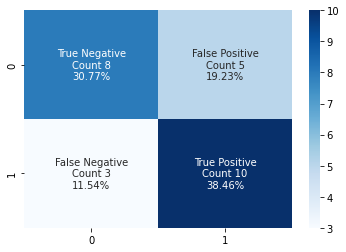

In [ ]:
# Logistic Regression results with dimension reduction.
result = test_model(x_transformed_and_reduced, y_balanced, LogisticRegression)
y_true, y_pred = result['y_true'], result['y_pred']
pca_lr_f1 = f1_score(y_true, y_pred)
print(pca_lr_f1)
plot_confustion_matrix(y_true, y_pred)


0.6428571428571429


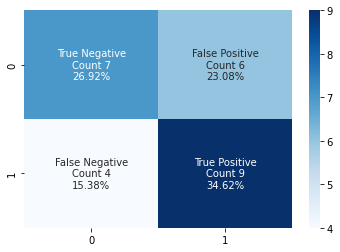

In [ ]:
# SVM with rbf kernel results with dimension reduction.
result = test_model(x_transformed_and_reduced, y_balanced, SVC, kernel='rbf')
y_true, y_pred = result['y_true'], result['y_pred']
pca_svm_rbf_f1 = f1_score(y_true, y_pred)
print(pca_svm_rbf_f1)
plot_confustion_matrix(y_true, y_pred)

0.7586206896551724


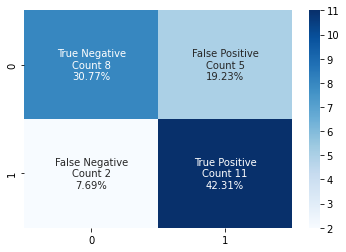

In [ ]:
# SVM with linear kernel results with dimension reduction
result = test_model(x_transformed_and_reduced, y_balanced, SVC, kernel='linear')
y_true, y_pred = result['y_true'], result['y_pred']
pca_svm_linear_f1 = f1_score(y_true, y_pred)
print(pca_svm_linear_f1)
plot_confustion_matrix(y_true, y_pred)

### Feature selection with variance threshold

In [ ]:
def feature_selection_with_variance_threshold(x: pd.DataFrame):
    x = x.copy()

    masks = []
    for variant in np.linspace(0.022, 0.075, num=10):
        selection = VarianceThreshold(threshold=variant)
        selection.fit_transform(x)
        masks.append(selection.get_support())
    
    return masks

masks = feature_selection_with_variance_threshold(x_balanced)
x_variants = [x_balanced.iloc[:, mask] for mask in masks]

#### Train multiple models with different amount of features.

In [ ]:
lr_results = [test_model(x_variant, y_balanced, LogisticRegression) for x_variant in x_variants]
svm_rbf_results = [test_model(x_variant, y_balanced, SVC, kernel='rbf') for x_variant in x_variants]
svm_linear_results = [test_model(x_variant, y_balanced, SVC, kernel='linear') for x_variant in x_variants]

#### Get the models with best f1 scores

Best Logistic Regression with feature selection f1 scores is: 0.7142857142857142
(128, 132)


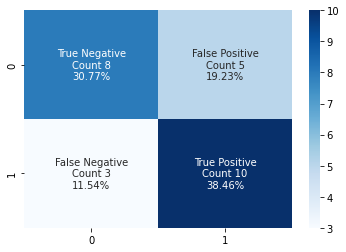

Best SVM rbf with feature selction f1 scores is: 0.6428571428571429
(128, 132)


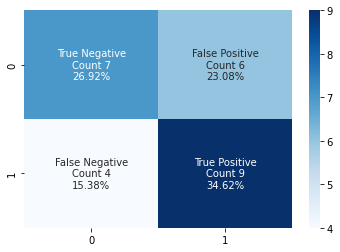

Best SVM linear with feature selection f1 scores is: 0.6666666666666667
(128, 132)


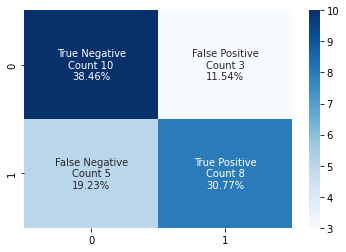

In [ ]:
sorted_lr_results = sorted(lr_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)
sorted_svm_rbf_results = sorted(svm_rbf_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)
sorted_svm_linear_results = sorted(svm_linear_results, key=lambda x: f1_score(x['y_true'], x['y_pred']), reverse=True)

best_lr_variant = sorted_lr_results[0]
best_svm_rbf_variant = sorted_svm_rbf_results[0]
best_svm_linear_variant = sorted_svm_linear_results[0]

fs_lr_f1 = f1_score(best_lr_variant["y_true"], best_lr_variant["y_pred"])
print(f'Best Logistic Regression with feature selection f1 scores is: {fs_lr_f1}')
print(best_lr_variant['x'].shape)
plot_confustion_matrix(best_lr_variant['y_true'], best_lr_variant['y_pred'])

fs_svm_rbf_f1 = f1_score(best_svm_rbf_variant["y_true"], best_svm_rbf_variant["y_pred"])
print(f'Best SVM rbf with feature selction f1 scores is: {fs_svm_rbf_f1}')
print(best_svm_rbf_variant['x'].shape)
plot_confustion_matrix(best_svm_rbf_variant['y_true'], best_svm_rbf_variant['y_pred'])

fs_svm_linear_f1 = f1_score(best_svm_linear_variant["y_true"], best_svm_linear_variant["y_pred"])
print(f'Best SVM linear with feature selection f1 scores is: {fs_svm_linear_f1}')
print(best_svm_linear_variant['x'].shape)
plot_confustion_matrix(best_svm_linear_variant['y_true'], best_svm_linear_variant['y_pred'])

#### Summary between basline, pca and feature selction

In [ ]:
print(f'Linear Regression:')
print(f'Baseline: {baseline_lr_f1}')
print(f'PCA: {pca_lr_f1}')
print(f'Feature Selection: {fs_lr_f1}')
print('')
print(f'SVM RBF:')
print(f'Baseline: {baseline_svm_rbf_f1}')
print(f'PCA: {pca_svm_rbf_f1}')
print(f'Feature Selection: {fs_svm_rbf_f1}')
print('')
print(f'SVM Linear:')
print(f'Baseline: {baseline_svm_linear_f1}')
print(f'PCA: {pca_svm_linear_f1}')
print(f'Feature Selection: {fs_svm_linear_f1}')
print('')
print('Feature selection did not improve the results.')
print('PCA improves the result on SVM linear but not on the rest.')

Linear Regression:
Baseline: 0.7586206896551724
PCA: 0.7142857142857142
Feature Selection: 0.7142857142857142

SVM RBF:
Baseline: 0.6428571428571429
PCA: 0.6428571428571429
Feature Selection: 0.6428571428571429

SVM Linear:
Baseline: 0.6666666666666667
PCA: 0.7586206896551724
Feature Selection: 0.6666666666666667

Feature selection did not improve the results.
PCA improves the result on SVM linear but not on the rest.


#### Model here we maximize fbeta scores on the minority class

This segment we will find the maximum beta score for our two models. We interpet the assignment as maximum between beta values: 0.5, 1 and 2.
We gonna start with the imbalanced dataset since we 
Because the assignment mentions minority class, We gonna start with the imbalanced dataset.

In [ ]:
def train_lr(x, y, beta):
    result = test_model(x, y, LogisticRegression)
    beta = fbeta_score(result['y_true'], result['y_pred'], average='macro', beta=beta)

    return {**result, 'fbeta_score': beta}


In [ ]:
results = [(train_lr(x_balanced, y_balanced, beta), beta) for beta in [0.5, 1, 2]]
for result, beta in results:
    print(f'Result for beta {beta}: {result["fbeta_score"]}')

Result for beta 0.5: 0.7345013477088949
Result for beta 1: 0.7271364317841079
Result for beta 2: 0.7269924098671727
